# Classification on imbalanced data

In [ ]:
!rm -rf ActuarialThesis
!git clone https://github.com/aderdouri/ActuarialThesis.git
%ls -ltr ActuarialThesis

Cloning into 'ActuarialThesis'...
remote: Enumerating objects: 1089, done.
remote: Counting objects: 100% (372/372), done.
remote: Compressing objects: 100% (260/260), done.
remote: Total 1089 (delta 203), reused 228 (delta 110), pack-reused 717
Receiving objects: 100% (1089/1089), 131.35 MiB | 20.49 MiB/s, done.
Resolving deltas: 100% (493/493), done.
total 24
drwxr-xr-x 2 root root 4096 Nov 12 13:42 Data/
drwxr-xr-x 2 root root 4096 Nov 12 13:42 EMTboost/
drwxr-xr-x 5 root root 4096 Nov 12 13:42 Notebooks/
drwxr-xr-x 2 root root 4096 Nov 12 13:42 R/
drwxr-xr-x 2 root root 4096 Nov 12 13:42 src/
-rw-r--r-- 1 root root   54 Nov 12 13:42 README.md


In [ ]:
!mkdir ActuarialThesis/plots_clf
!ls -ltr ActuarialThesis/plots_clf

total 0


In [ ]:
# Ajouter le répértoire src
import sys
sys.path.insert(0,'./ActuarialThesis/src/')

In [ ]:
import installHelper

In [ ]:
# Installer les packages nécéssaires
%time installHelper.installALL()

CPU times: user 921 ms, sys: 118 ms, total: 1.04 s
Wall time: 2min 52s


In [ ]:
# On doit trouver tous les packages mentionés dans le grep
!pip list -v | grep -e catboost -e 'imbalanced-learn' -e 'optuna' -e 'catboost' -e 'lime' -e 'shap'

catboost                         1.2.2                 /usr/local/lib/python3.10/dist-packages pip
imbalanced-learn                 0.10.1                /usr/local/lib/python3.10/dist-packages pip
lime                             0.2.0.1               /usr/local/lib/python3.10/dist-packages pip
optuna                           3.4.0                 /usr/local/lib/python3.10/dist-packages pip
shap                             0.43.0                /usr/local/lib/python3.10/dist-packages pip
shapely                          2.0.2                 /usr/local/lib/python3.10/dist-packages pip


In [ ]:
# Importer les packages nécéssaires
from helper import *

In [ ]:
# Appliquer le theme par défaut
sns.set_theme()

In [ ]:
#!pip install scikit-plot

In [ ]:
import tensorflow as tf
from tensorflow import keras
import os
import tempfile
import sklearn
import scikitplot as skplt

In [ ]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
file = tf.keras.utils

In [ ]:
df = pd.read_csv('ActuarialThesis/Data/encodedBASEAUTO.csv')
df.head()

,ACV,SEX,STATUT,AGECOND,K8000,RM,CAR,USAGE_Prive,USAGE_PriveTrajet,USAGE_Professionnel,...,SEGM_H,SEGM_M1,SEGM_M2,GARAGE_ClosCollectif,GARAGE_GarageAutre,GARAGE_IndividuelClos,CSP_CSP_50,CSP_CSP_60,CSP_CSP_AUTRE,CHARGE
0,1.134929,1,1,-0.457663,0,-0.094064,0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
1,1.134929,1,0,1.101165,0,-0.817279,0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
2,1.134929,1,1,-1.813166,0,1.507343,0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,1.134929,1,0,0.626739,0,-0.817279,0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
4,1.134929,1,0,-1.203190,0,1.507343,0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


In [ ]:
df['CHARGE'] = df['CHARGE'].map(lambda val: 0 if val<=0 else 1)

In [ ]:
X = df.drop('CHARGE', axis=1)
y = df['CHARGE']

### Examine the class label imbalance

Let's look at the dataset imbalance:

In [ ]:
neg, pos = np.bincount(y)
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 10496
    Positive: 1398 (13.32% of total)



This shows the small fraction of positive samples.

In [ ]:
# Use a utility from sklearn to split and shuffle your dataset.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=13)
X_train, X_val, y_train, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=13)

In [ ]:
# Form np arrays of labels and features.
train_labels = np.array(y_train)
bool_train_labels = train_labels != 0
val_labels = np.array(y_val)
test_labels = np.array(y_test)

train_features = np.array(X_train)
val_features = np.array(X_val)
test_features = np.array(X_test)

## Define the model and metrics

Define a function that creates a simple neural network with a densly connected hidden layer, a [dropout](https://developers.google.com/machine-learning/glossary/#dropout_regularization) layer to reduce overfitting, and an output sigmoid layer that returns the probability of a transaction being fraudulent:

In [ ]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'),
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

def make_model(metrics=METRICS, output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  model = keras.Sequential([
      keras.layers.Dense(
          16, activation='relu',
          input_shape=(train_features.shape[-1],)),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(1, activation='sigmoid',
                         bias_initializer=output_bias),
  ])

  model.compile(
      optimizer=keras.optimizers.Adam(learning_rate=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

  return model

## Baseline model

### Build the model

Now create and train your model using the function that was defined earlier. Notice that the model is fit using a larger than default batch size of 2048, this is important to ensure that each batch has a decent chance of containing a few positive samples. If the batch size was too small, they would likely have no fraudulent transactions to learn from.


Note: this model will not handle the class imbalance well. You will improve it later in this tutorial.

In [ ]:
EPOCHS = 100
BATCH_SIZE = 512 # 2048

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_prc',
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [ ]:
model = make_model()
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_22 (Dense)            (None, 16)                1088      
                                                                 
 dropout_11 (Dropout)        (None, 16)                0         
                                                                 
 dense_23 (Dense)            (None, 1)                 17        
                                                                 
Total params: 1105 (4.32 KB)
Trainable params: 1105 (4.32 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Test run the model:

In [ ]:
model.predict(train_features[:10])

1/1 [==============================] - 0s 64ms/step


array([[0.6856751 ],
       [0.41270366],
       [0.5967347 ],
       [0.6064431 ],
       [0.6926734 ],
       [0.55121356],
       [0.6993229 ],
       [0.6209798 ],
       [0.6647922 ],
       [0.61830807]], dtype=float32)

### Optional: Set the correct initial bias.

These initial guesses are not great. You know the dataset is imbalanced. Set the output layer's bias to reflect that (See: [A Recipe for Training Neural Networks: "init well"](http://karpathy.github.io/2019/04/25/recipe/#2-set-up-the-end-to-end-trainingevaluation-skeleton--get-dumb-baselines)). This can help with initial convergence.

With the default bias initialization the loss should be about `math.log(2) = 0.69314`

In [ ]:
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 0.8885


The correct bias to set can be derived from:

$$ p_0 = pos/(pos + neg) = 1/(1+e^{-b_0}) $$
$$ b_0 = -log_e(1/p_0 - 1) $$
$$ b_0 = log_e(pos/neg)$$

In [ ]:
initial_bias = np.log([pos/neg])
initial_bias

array([-1.87301197])

Set that as the initial bias, and the model will give much more reasonable initial guesses.

It should be near: `pos/total = 0.0018`

In [ ]:
model = make_model(output_bias=initial_bias)
model.predict(train_features[:10])

1/1 [==============================] - 0s 87ms/step


array([[0.08285158],
       [0.16896702],
       [0.09733837],
       [0.16622275],
       [0.27545205],
       [0.14016974],
       [0.27843317],
       [0.07338744],
       [0.1316762 ],
       [0.15955244]], dtype=float32)

With this initialization the initial loss should be approximately:

$$-p_0log(p_0)-(1-p_0)log(1-p_0) = 0.01317$$

In [ ]:
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 0.3741


This initial loss is about 50 times less than if would have been with naive initialization.

This way the model doesn't need to spend the first few epochs just learning that positive examples are unlikely. This also makes it easier to read plots of the loss during training.

### Checkpoint the initial weights

To make the various training runs more comparable, keep this initial model's weights in a checkpoint file, and load them into each model before training:

In [ ]:
initial_weights = os.path.join(tempfile.mkdtemp(), 'initial_weights')
model.save_weights(initial_weights)

### Confirm that the bias fix helps

Before moving on, confirm quick that the careful bias initialization actually helped.

Train the model for 20 epochs, with and without this careful initialization, and compare the losses:

In [ ]:
model = make_model()
model.load_weights(initial_weights)
model.layers[-1].bias.assign([0.0])
zero_bias_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(val_features, val_labels),
    verbose=0)

In [ ]:
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_26 (Dense)            (None, 16)                1088      
                                                                 
 dropout_13 (Dropout)        (None, 16)                0         
                                                                 
 dense_27 (Dense)            (None, 1)                 17        
                                                                 
Total params: 1105 (4.32 KB)
Trainable params: 1105 (4.32 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model = make_model()
model.load_weights(initial_weights)
careful_bias_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(val_features, val_labels),
    verbose=0)

In [ ]:
def plot_loss(history, label, n):
  # Use a log scale on y-axis to show the wide range of values.
  plt.semilogy(history.epoch, history.history['loss'],
               color=colors[n], label='Train ' + label)
  plt.semilogy(history.epoch, history.history['val_loss'],
               color=colors[n], label='Val ' + label,
               linestyle="--")
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()

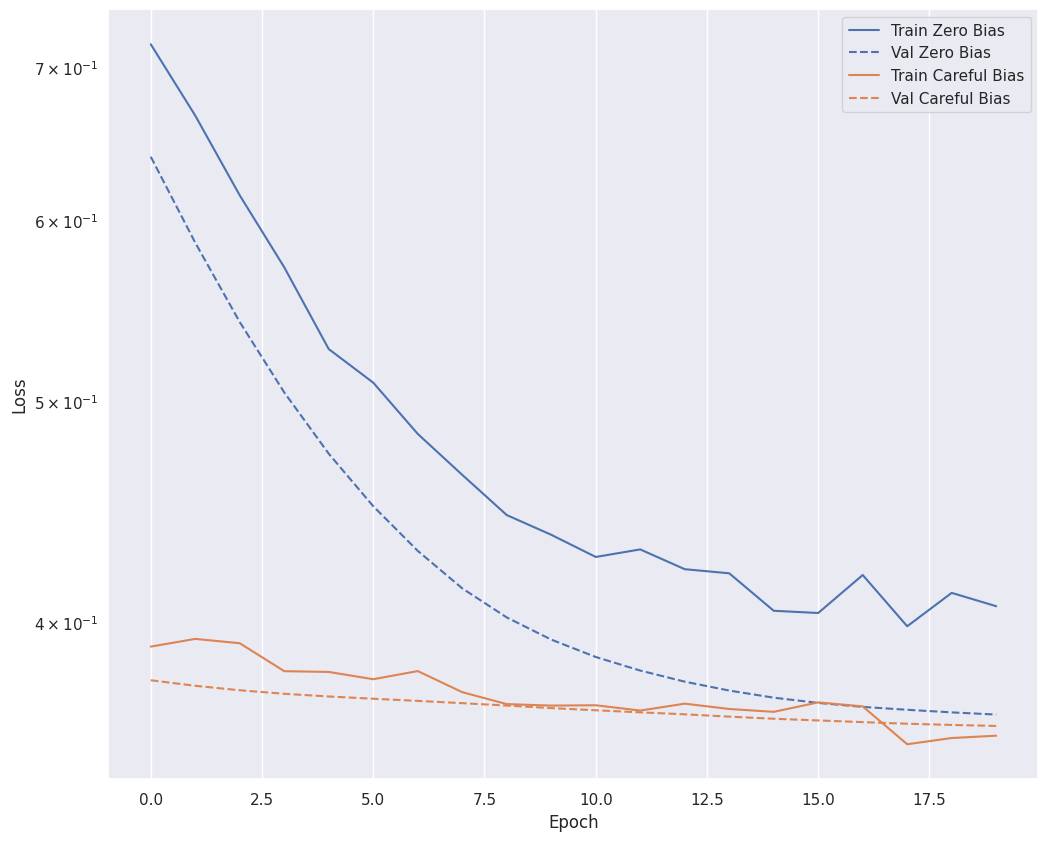

In [ ]:
plot_loss(zero_bias_history, "Zero Bias", 0)
plot_loss(careful_bias_history, "Careful Bias", 1)

The above figure makes it clear: In terms of validation loss, on this problem, this careful initialization gives a clear advantage.

### Train the model

In [ ]:
model = make_model()
model.load_weights(initial_weights)
baseline_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(val_features, val_labels))

Epoch 1/100
5/5 [==============================] - 3s 176ms/step - loss: 0.3968 - tp: 1.0000 - fp: 8.0000 - tn: 3647.0000 - fn: 543.0000 - accuracy: 0.8688 - precision: 0.1111 - recall: 0.0018 - auc: 0.6311 - prc: 0.1660 - val_loss: 0.3775 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 1826.0000 - val_fn: 274.0000 - val_accuracy: 0.8695 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6231 - val_prc: 0.1664
Epoch 2/100
5/5 [==============================] - 0s 31ms/step - loss: 0.3912 - tp: 1.0000 - fp: 4.0000 - tn: 1825.0000 - fn: 269.0000 - accuracy: 0.8699 - precision: 0.2000 - recall: 0.0037 - auc: 0.5743 - prc: 0.1549 - val_loss: 0.3756 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 1826.0000 - val_fn: 274.0000 - val_accuracy: 0.8695 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6346 - val_prc: 0.1714
Epoch 3/100
5/5 [==============================] - 0s 31ms/step - loss: 0.3892 - tp: 0.0000e+00 - fp: 3.0000 - tn: 1826.0000 - fn: 270.

### Check training history

In this section, you will produce plots of your model's accuracy and loss on the training and validation set. These are useful to check for overfitting, which you can learn more about in the [Overfit and underfit](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit) tutorial.

Additionally, you can produce these plots for any of the metrics you created above. False negatives are included as an example.

In [ ]:
def plot_metrics(history):
  metrics = ['loss', 'prc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

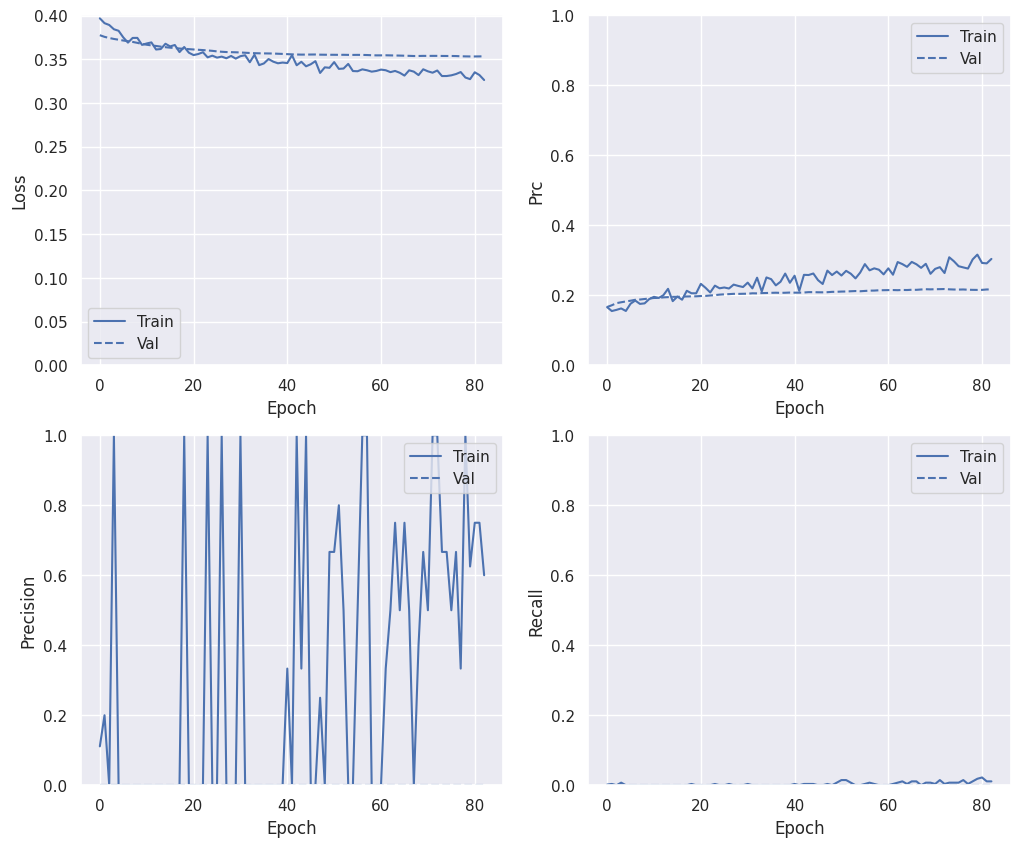

In [ ]:
plot_metrics(baseline_history)

Note: That the validation curve generally performs better than the training curve. This is mainly caused by the fact that the dropout layer is not active when evaluating the model.

### Evaluate metrics

You can use a [confusion matrix](https://developers.google.com/machine-learning/glossary/#confusion_matrix) to summarize the actual vs. predicted labels, where the X axis is the predicted label and the Y axis is the actual label:

In [ ]:
train_predictions_baseline = model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_baseline = model.predict(test_features, batch_size=BATCH_SIZE)

9/9 [==============================] - 0s 2ms/step


In [ ]:
def plot_cm(labels, predictions, p=0.5):
  predictions = predictions > p
  cm = confusion_matrix(labels, predictions)
  skplt.metrics.plot_confusion_matrix(labels, predictions, normalize=True)
  fig = plt.gcf()
  fig.set_size_inches(5, 5)
  print('Accuracy (balanced): {:.5f}'.format(balanced_accuracy_score(labels, predictions)))

In [ ]:
def plot_classification_report_confusion_matrix(model, X_test, y_test):
  fig, (ax1, ax2) = plt.subplots(1, 2)

  y_pred = model.predict(X_test, batch_size=BATCH_SIZE)
  y_pred = y_pred>0.5

  clf_report = classification_report(y_test, y_pred, output_dict=True)

  clf_report_df = pd.DataFrame(clf_report)
  clf_report_df.drop(['support'], inplace=True)

  ax = sns.heatmap(clf_report_df.T,
              annot=True,
              cbar=False,
              square=False,
              fmt='g',
              linewidths=0.9,
              cmap=plt.cm.Blues,
              ax=ax1
              );
  ax.xaxis.tick_top()
  ax.set_title('Classification report')
  ax.set_xlabel('Accuracy (balanced): {:.5f}'.format(balanced_accuracy_score(y_test, y_pred)))

  skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True, ax=ax2)

  fig = plt.gcf()
  return fig


9/9 [==============================] - 0s 2ms/step


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


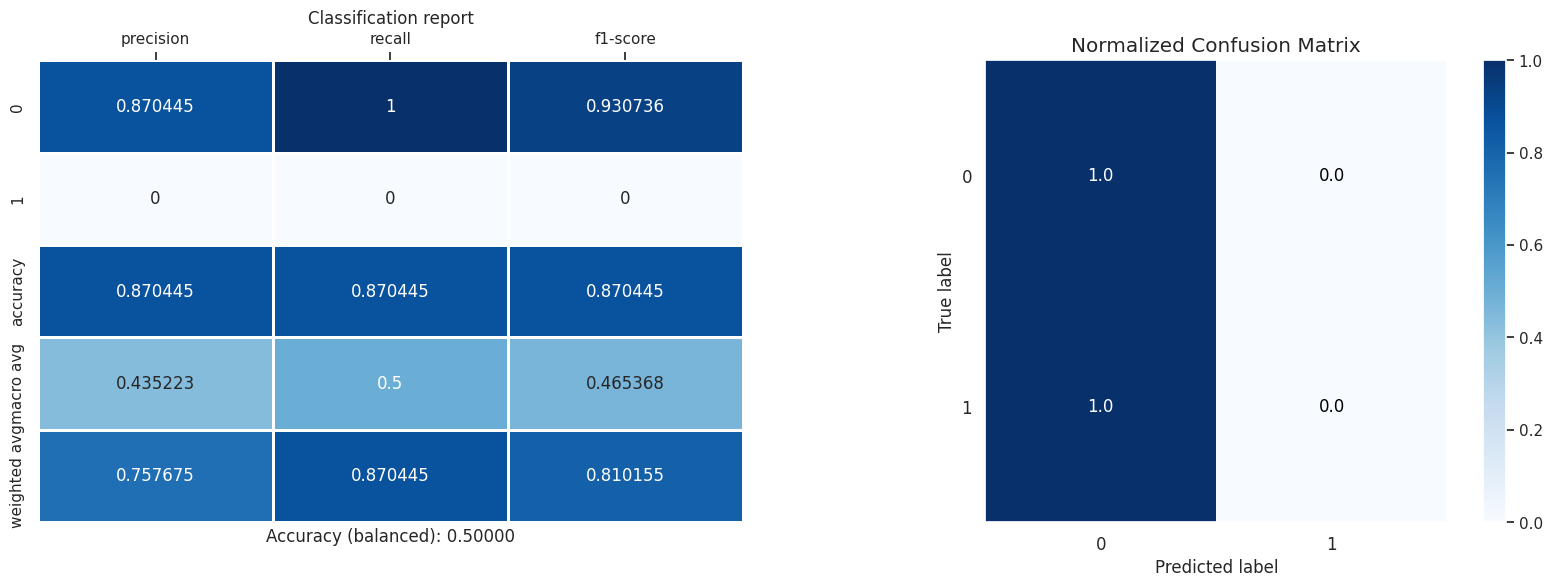

In [ ]:
fig = my_plot_classification_report_confusion_matrix(model, X_test, y_test)
fig.set_size_inches(20, 6)
fig.savefig('./ActuarialThesis/plots_clf/myCatBoostClassifierConfusionMatrix.pdf', bbox_inches='tight')

Evaluate your model on the test dataset and display the results for the metrics you created above:

If the model had predicted everything perfectly, this would be a [diagonal matrix](https://en.wikipedia.org/wiki/Diagonal_matrix) where values off the main diagonal, indicating incorrect predictions, would be zero. In this case the matrix shows that you have relatively few false positives, meaning that there were relatively few legitimate transactions that were incorrectly flagged. However, you would likely want to have even fewer false negatives despite the cost of increasing the number of false positives. This trade off may be preferable because false negatives would allow fraudulent transactions to go through, whereas false positives may cause an email to be sent to a customer to ask them to verify their card activity.

### Plot the ROC

Now plot the [ROC](https://developers.google.com/machine-learning/glossary#ROC). This plot is useful because it shows, at a glance, the range of performance the model can reach just by tuning the output threshold.

In [ ]:
def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

  plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  #plt.xlim([-0.5,20])
  #plt.ylim([-80,100.5])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

In [ ]:
fp, tp, _ = sklearn.metrics.roc_curve(train_labels, train_predictions_baseline)
np.max(fp), np.max(tp)

(1.0, 1.0)

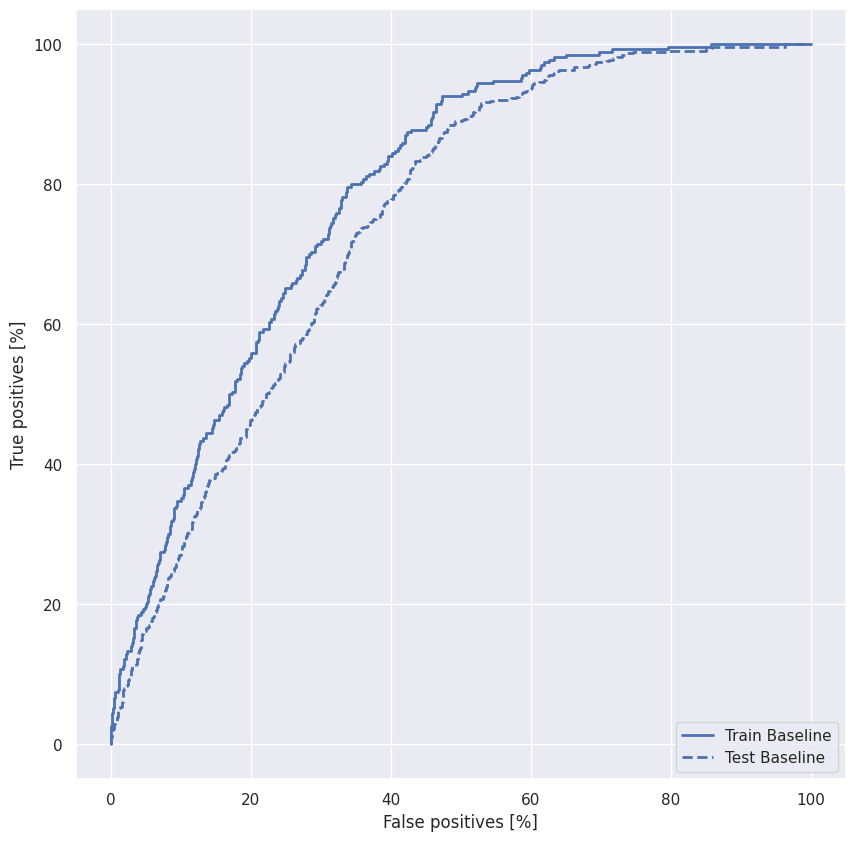

In [ ]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right');

### Plot the AUPRC

Now plot the [AUPRC](https://developers.google.com/machine-learning/glossary?hl=en#PR_AUC). Area under the interpolated precision-recall curve, obtained by plotting (recall, precision) points for different values of the classification threshold. Depending on how it's calculated, PR AUC may be equivalent to the average precision of the model.


In [ ]:
def plot_prc(name, labels, predictions, **kwargs):
    precision, recall, _ = sklearn.metrics.precision_recall_curve(labels, predictions)

    plt.plot(precision, recall, label=name, linewidth=2, **kwargs)
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

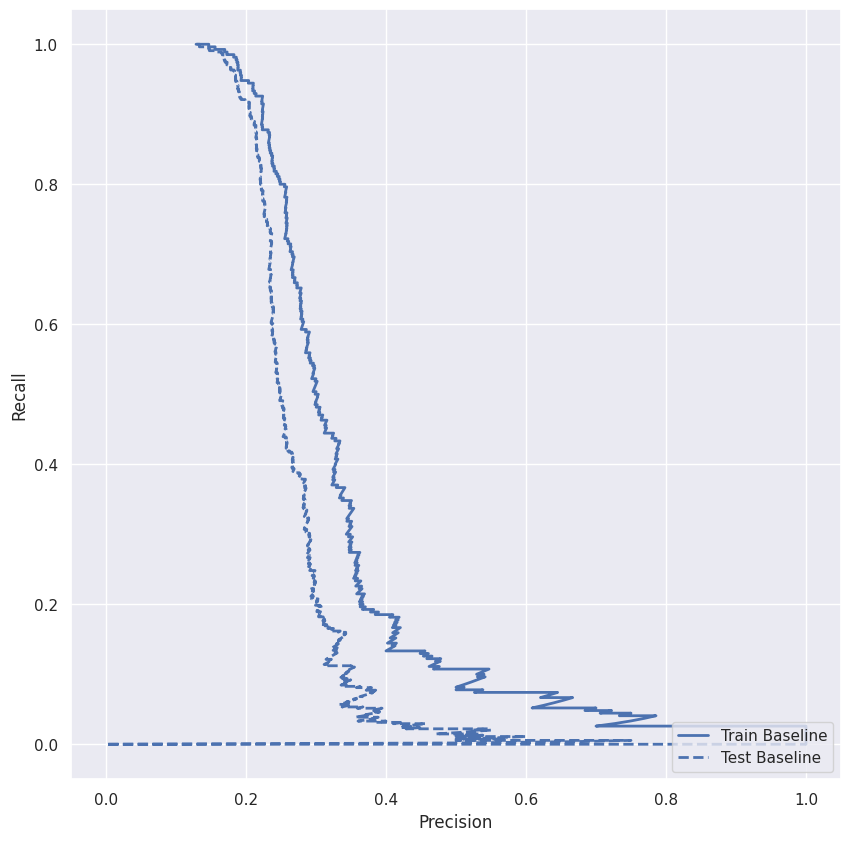

In [ ]:
plot_prc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_prc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right');

It looks like the precision is relatively high, but the recall and the area under the ROC curve (AUC) aren't as high as you might like. Classifiers often face challenges when trying to maximize both precision and recall, which is especially true when working with imbalanced datasets. It is important to consider the costs of different types of errors in the context of the problem you care about. In this example, a false negative (a fraudulent transaction is missed) may have a financial cost, while a false positive (a transaction is incorrectly flagged as fraudulent) may decrease user happiness.

## Class weights

### Calculate class weights

The goal is to identify fraudulent transactions, but you don't have very many of those positive samples to work with, so you would want to have the classifier heavily weight the few examples that are available. You can do this by passing Keras weights for each class through a parameter. These will cause the model to "pay more attention" to examples from an under-represented class.

In [ ]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.58
Weight for class 1: 3.75


### Train a model with class weights

Now try re-training and evaluating the model with class weights to see how that affects the predictions.

Note: Using `class_weights` changes the range of the loss. This may affect the stability of the training depending on the optimizer. Optimizers whose step size is dependent on the magnitude of the gradient, like `tf.keras.optimizers.SGD`, may fail. The optimizer used here, `tf.keras.optimizers.Adam`, is unaffected by the scaling change. Also note that because of the weighting, the total losses are not comparable between the two models.

In [ ]:
weighted_model = make_model()
weighted_model.load_weights(initial_weights)

weighted_history = weighted_model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(val_features, val_labels),
    # The class weights go here
    class_weight=class_weight)

Epoch 1/100
5/5 [==============================] - 2s 180ms/step - loss: 0.9918 - tp: 3.0000 - fp: 10.0000 - tn: 5474.0000 - fn: 811.0000 - accuracy: 0.8696 - precision: 0.2308 - recall: 0.0037 - auc: 0.6870 - prc: 0.1981 - val_loss: 0.3835 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 1826.0000 - val_fn: 274.0000 - val_accuracy: 0.8695 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6045 - val_prc: 0.1596
Epoch 2/100
5/5 [==============================] - 0s 33ms/step - loss: 0.9723 - tp: 4.0000 - fp: 17.0000 - tn: 1812.0000 - fn: 266.0000 - accuracy: 0.8652 - precision: 0.1905 - recall: 0.0148 - auc: 0.5475 - prc: 0.1393 - val_loss: 0.3882 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 1826.0000 - val_fn: 274.0000 - val_accuracy: 0.8695 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6055 - val_prc: 0.1609
Epoch 3/100
5/5 [==============================] - 0s 37ms/step - loss: 0.9205 - tp: 7.0000 - fp: 29.0000 - tn: 1800.0000 - fn: 263.0

### Check training history

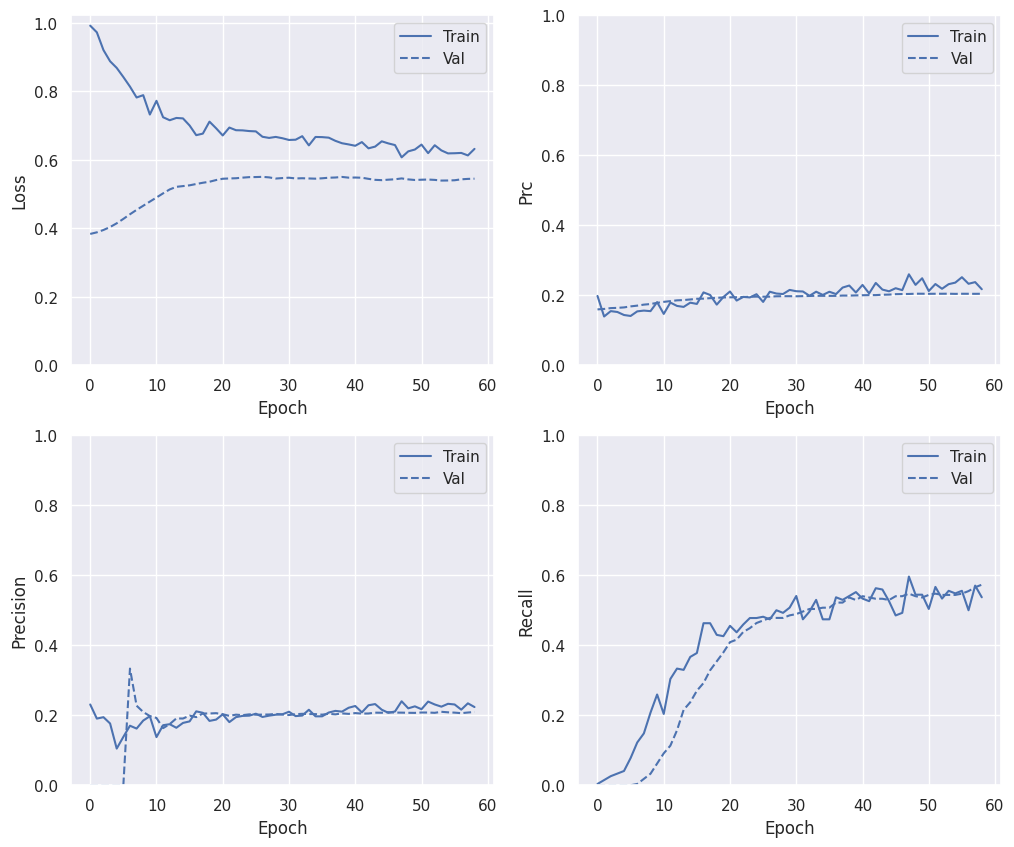

In [ ]:
plot_metrics(weighted_history)

### Evaluate metrics

In [ ]:
train_predictions_weighted = weighted_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_weighted = weighted_model.predict(test_features, batch_size=BATCH_SIZE)

9/9 [==============================] - 0s 2ms/step


9/9 [==============================] - 0s 6ms/step


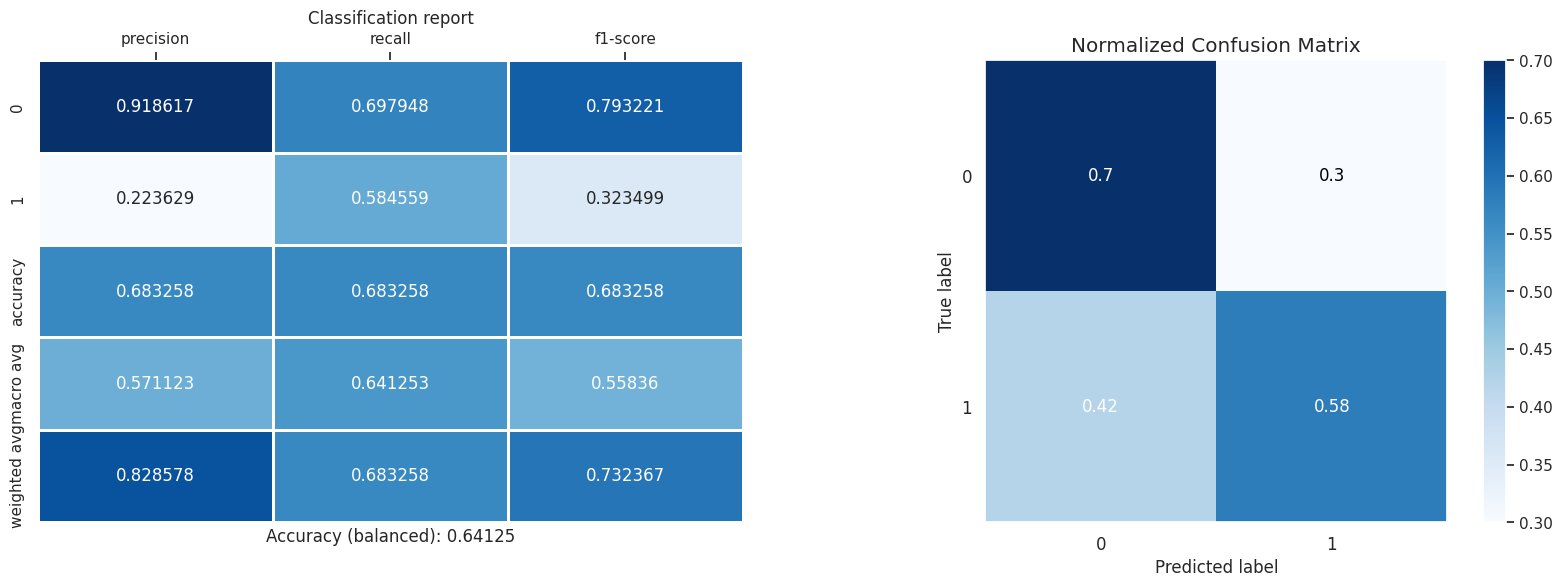

In [ ]:
fig = my_plot_classification_report_confusion_matrix(weighted_model, X_test, y_test)
fig.set_size_inches(20, 6)
fig.savefig('./ActuarialThesis/plots_clf/myCatBoostClassifierConfusionMatrix.pdf', bbox_inches='tight')

Here you can see that with class weights the accuracy and precision are lower because there are more false positives, but conversely the recall and AUC are higher because the model also found more true positives. Despite having lower accuracy, this model has higher recall (and identifies more fraudulent transactions). Of course, there is a cost to both types of error (you wouldn't want to bug users by flagging too many legitimate transactions as fraudulent, either). Carefully consider the trade-offs between these different types of errors for your application.

9/9 [==============================] - 0s 4ms/step


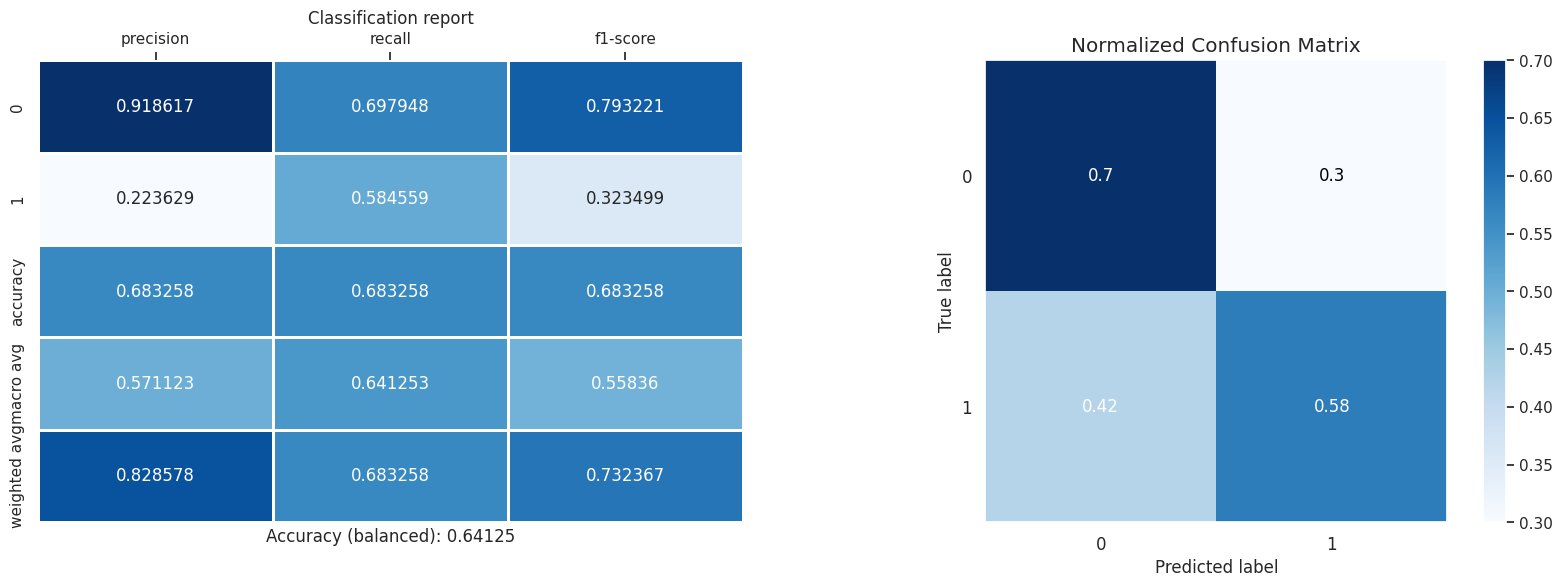

In [ ]:
fig = plot_classification_report_confusion_matrix(weighted_model, X_test, y_test)
fig.set_size_inches(20, 6)
fig.savefig('./ActuarialThesis/plots_clf/myCatBoostClassifierConfusionMatrix.pdf', bbox_inches='tight')

### Plot the ROC

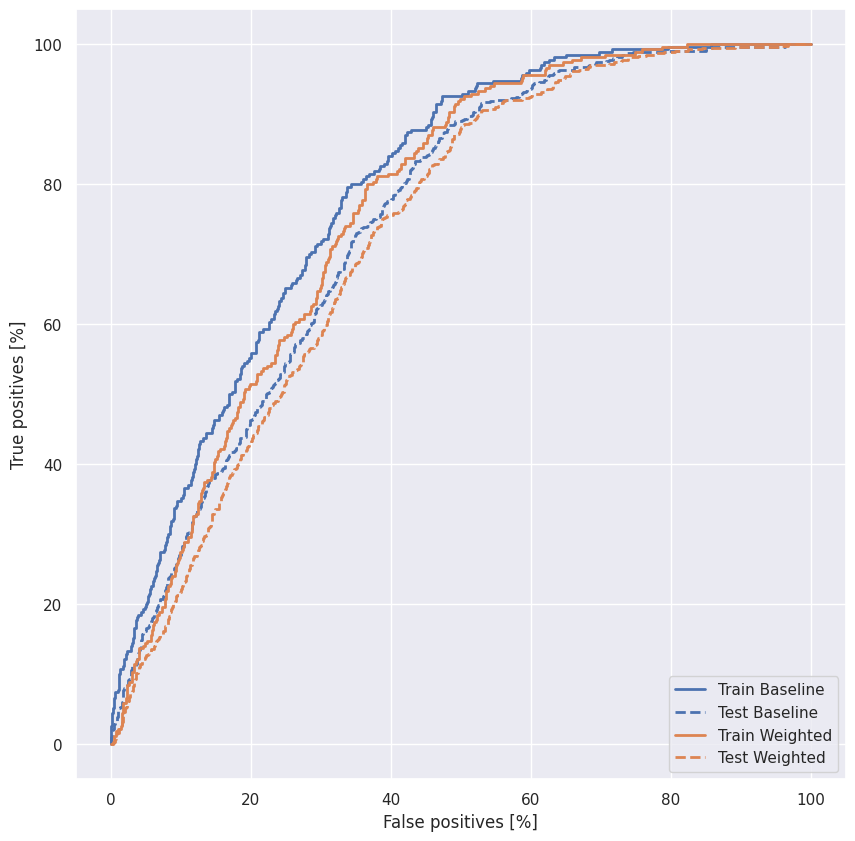

In [ ]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_roc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_roc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')


plt.legend(loc='lower right');

### Plot the AUPRC

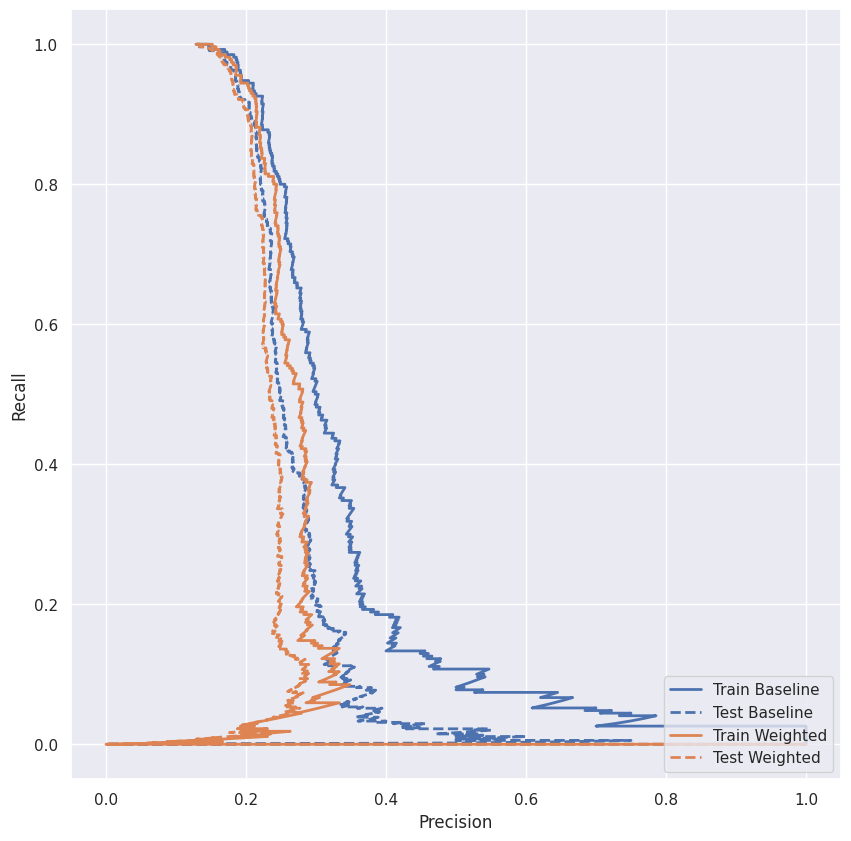

In [ ]:
plot_prc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_prc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_prc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_prc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')


plt.legend(loc='lower right');

## Oversampling

### Oversample the minority class

A related approach would be to resample the dataset by oversampling the minority class.

In [ ]:
pos_features = train_features[bool_train_labels]
neg_features = train_features[~bool_train_labels]

pos_labels = train_labels[bool_train_labels]
neg_labels = train_labels[~bool_train_labels]

#### Using NumPy

You can balance the dataset manually by choosing the right number of random
indices from the positive examples:

In [ ]:
ids = np.arange(len(pos_features))
choices = np.random.choice(ids, len(neg_features))

res_pos_features = pos_features[choices]
res_pos_labels = pos_labels[choices]

res_pos_features.shape

(1829, 67)

In [ ]:
resampled_features = np.concatenate([res_pos_features, neg_features], axis=0)
resampled_labels = np.concatenate([res_pos_labels, neg_labels], axis=0)

order = np.arange(len(resampled_labels))
np.random.shuffle(order)
resampled_features = resampled_features[order]
resampled_labels = resampled_labels[order]

resampled_features.shape

(3658, 67)

#### Using `tf.data`

If you're using `tf.data` the easiest way to produce balanced examples is to start with a `positive` and a `negative` dataset, and merge them. See [the tf.data guide](../../guide/data.ipynb) for more examples.

In [ ]:
BUFFER_SIZE = 100000

def make_ds(features, labels):
  ds = tf.data.Dataset.from_tensor_slices((features, labels))#.cache()
  ds = ds.shuffle(BUFFER_SIZE).repeat()
  return ds

pos_ds = make_ds(pos_features, pos_labels)
neg_ds = make_ds(neg_features, neg_labels)

Each dataset provides `(feature, label)` pairs:

In [ ]:
for features, label in pos_ds.take(1):
  print("Features:\n", features.numpy())
  print()
  print("Label: ", label.numpy())

Features:
 [ 0.29146683  0.          1.         -1.47429045  0.          1.76563384
  0.          0.          1.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          1.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          1.
  0.          0.          1.          0.          0.          0.
  0.          0.          1.          0.          0.          0.
  0.          0.          0.          0.          0.          1.
  0.          0.          1.          0.          1.          0.
  0.        ]

Label:  1


Merge the two together using `tf.data.Dataset.sample_from_datasets`:

In [ ]:
resampled_ds = tf.data.Dataset.sample_from_datasets([pos_ds, neg_ds], weights=[0.5, 0.5])
resampled_ds = resampled_ds.batch(BATCH_SIZE).prefetch(2)

In [ ]:
for features, label in resampled_ds.take(1):
  print(label.numpy().mean())

0.51953125


To use this dataset, you'll need the number of steps per epoch.

The definition of "epoch" in this case is less clear. Say it's the number of batches required to see each negative example once:

In [ ]:
resampled_steps_per_epoch = np.ceil(2.0*neg/BATCH_SIZE)
resampled_steps_per_epoch

36.0

### Train on the oversampled data

Now try training the model with the resampled data set instead of using class weights to see how these methods compare.

Note: Because the data was balanced by replicating the positive examples, the total dataset size is larger, and each epoch runs for more training steps.

In [ ]:
resampled_model = make_model()
resampled_model.load_weights(initial_weights)

# Reset the bias to zero, since this dataset is balanced.
output_layer = resampled_model.layers[-1]
output_layer.bias.assign([0])

val_ds = tf.data.Dataset.from_tensor_slices((val_features, val_labels)).cache()
val_ds = val_ds.batch(BATCH_SIZE).prefetch(2)

resampled_history = resampled_model.fit(
    resampled_ds,
    epochs=EPOCHS,
    steps_per_epoch=resampled_steps_per_epoch,
    callbacks=[early_stopping],
    validation_data=val_ds)

Epoch 1/100
36/36 [==============================] - 4s 59ms/step - loss: 0.6777 - tp: 5804.0000 - fp: 5094.0000 - tn: 7767.0000 - fn: 3966.0000 - accuracy: 0.5997 - precision: 0.5326 - recall: 0.5941 - auc: 0.6499 - prc: 0.5391 - val_loss: 0.6252 - val_tp: 174.0000 - val_fp: 701.0000 - val_tn: 1125.0000 - val_fn: 100.0000 - val_accuracy: 0.6186 - val_precision: 0.1989 - val_recall: 0.6350 - val_auc: 0.6731 - val_prc: 0.1888
Epoch 2/100
36/36 [==============================] - 1s 37ms/step - loss: 0.6366 - tp: 6259.0000 - fp: 3739.0000 - tn: 5502.0000 - fn: 2932.0000 - accuracy: 0.6381 - precision: 0.6260 - recall: 0.6810 - auc: 0.6820 - prc: 0.6359 - val_loss: 0.6157 - val_tp: 187.0000 - val_fp: 743.0000 - val_tn: 1083.0000 - val_fn: 87.0000 - val_accuracy: 0.6048 - val_precision: 0.2011 - val_recall: 0.6825 - val_auc: 0.6891 - val_prc: 0.1981
Epoch 3/100
36/36 [==============================] - 1s 29ms/step - loss: 0.6131 - tp: 6515.0000 - fp: 3595.0000 - tn: 5669.0000 - fn: 2653.000

If the training process were considering the whole dataset on each gradient update, this oversampling would be basically identical to the class weighting.

But when training the model batch-wise, as you did here, the oversampled data provides a smoother gradient signal: Instead of each positive example being shown in one batch with a large weight, they're shown in many different batches each time with a small weight.

This smoother gradient signal makes it easier to train the model.

### Check training history

Note that the distributions of metrics will be different here, because the training data has a totally different distribution from the validation and test data.

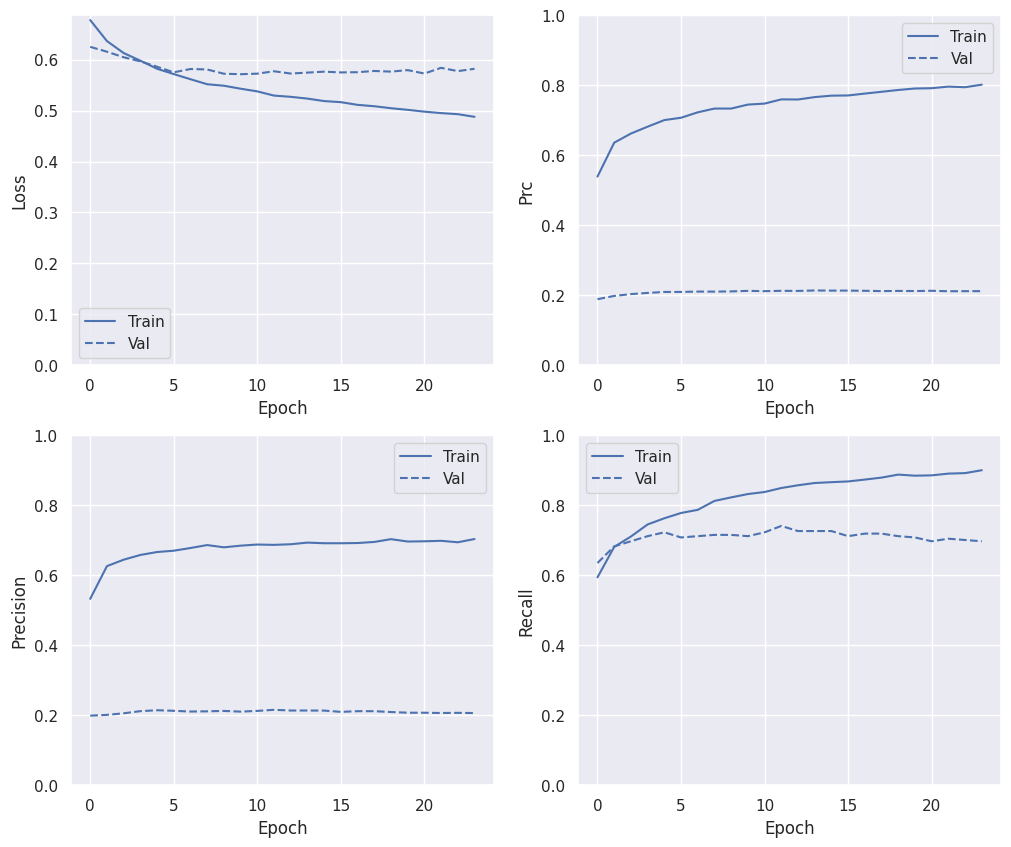

In [ ]:
plot_metrics(resampled_history)

### Re-train


Because training is easier on the balanced data, the above training procedure may overfit quickly.

So break up the epochs to give the `tf.keras.callbacks.EarlyStopping` finer control over when to stop training.

In [ ]:
resampled_model = make_model()
resampled_model.load_weights(initial_weights)

# Reset the bias to zero, since this dataset is balanced.
output_layer = resampled_model.layers[-1]
output_layer.bias.assign([0])

resampled_history = resampled_model.fit(
    resampled_ds,
    # These are not real epochs
    steps_per_epoch=20,
    epochs=10*EPOCHS,
    callbacks=[early_stopping],
    validation_data=(val_ds))

Epoch 1/1000
20/20 [==============================] - 3s 58ms/step - loss: 0.6866 - tp: 3332.0000 - fp: 3039.0000 - tn: 3888.0000 - fn: 2081.0000 - accuracy: 0.5851 - precision: 0.5230 - recall: 0.6156 - auc: 0.6214 - prc: 0.5098 - val_loss: 0.6379 - val_tp: 166.0000 - val_fp: 724.0000 - val_tn: 1102.0000 - val_fn: 108.0000 - val_accuracy: 0.6038 - val_precision: 0.1865 - val_recall: 0.6058 - val_auc: 0.6563 - val_prc: 0.1814
Epoch 2/1000
20/20 [==============================] - 0s 22ms/step - loss: 0.6605 - tp: 3091.0000 - fp: 2043.0000 - tn: 3080.0000 - fn: 2026.0000 - accuracy: 0.6026 - precision: 0.6021 - recall: 0.6041 - auc: 0.6438 - prc: 0.6020 - val_loss: 0.6240 - val_tp: 176.0000 - val_fp: 719.0000 - val_tn: 1107.0000 - val_fn: 98.0000 - val_accuracy: 0.6110 - val_precision: 0.1966 - val_recall: 0.6423 - val_auc: 0.6777 - val_prc: 0.1922
Epoch 3/1000
20/20 [==============================] - 0s 24ms/step - loss: 0.6395 - tp: 3421.0000 - fp: 2082.0000 - tn: 3025.0000 - fn: 1712.

### Re-check training history

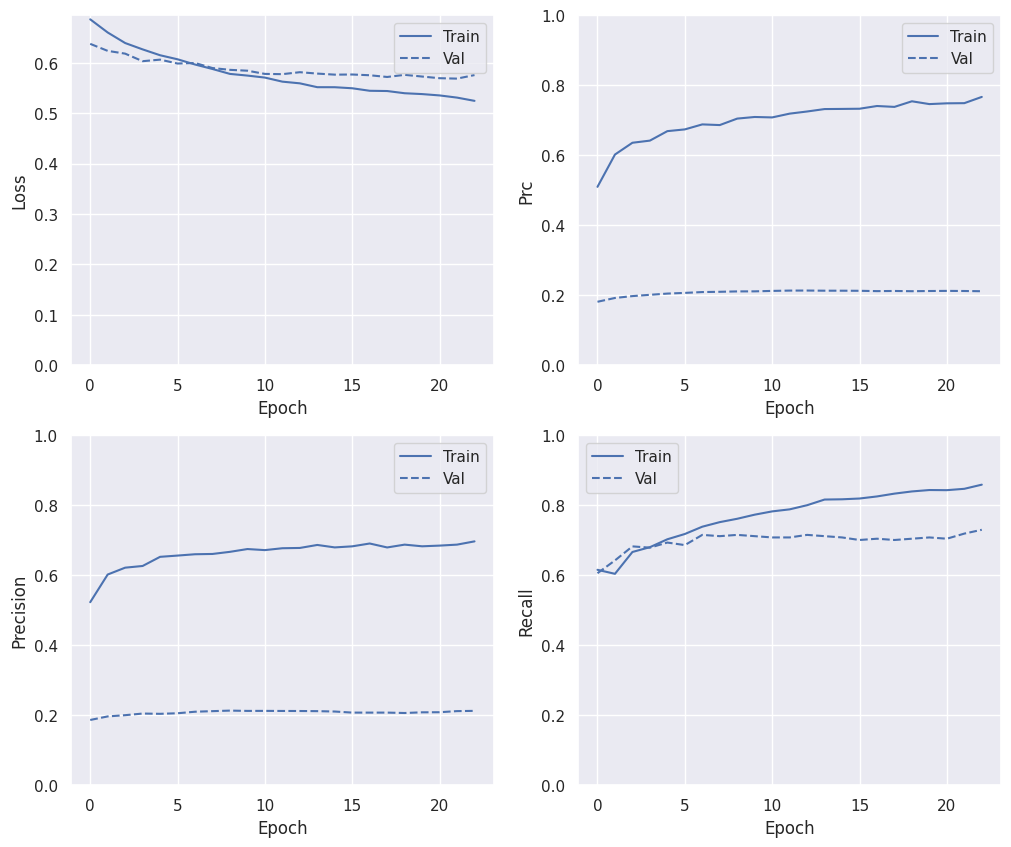

In [ ]:
plot_metrics(resampled_history)

### Evaluate metrics

In [ ]:
train_predictions_resampled = resampled_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_resampled = resampled_model.predict(test_features, batch_size=BATCH_SIZE)

9/9 [==============================] - 0s 2ms/step


9/9 [==============================] - 0s 2ms/step


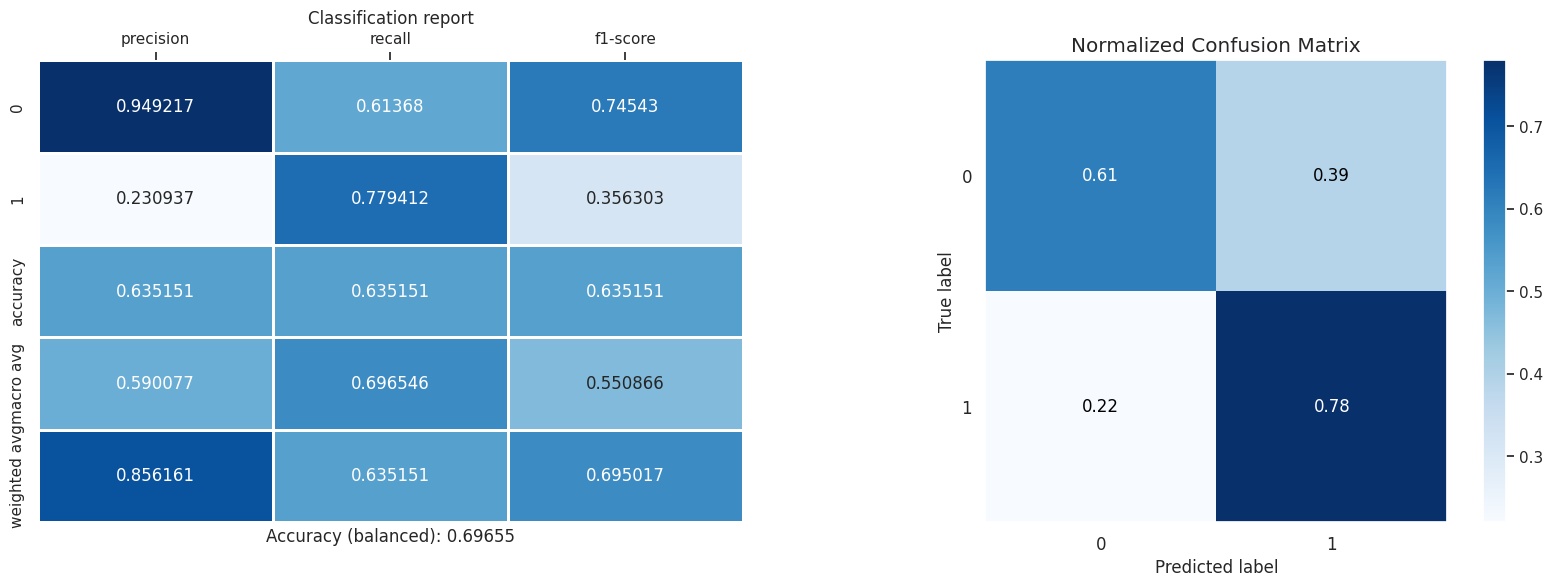

In [ ]:
fig = plot_classification_report_confusion_matrix(resampled_model, X_test, y_test)
fig.set_size_inches(20, 6)
fig.savefig('./ActuarialThesis/plots_clf/myCatBoostClassifierConfusionMatrix.pdf', bbox_inches='tight')

### Plot the ROC

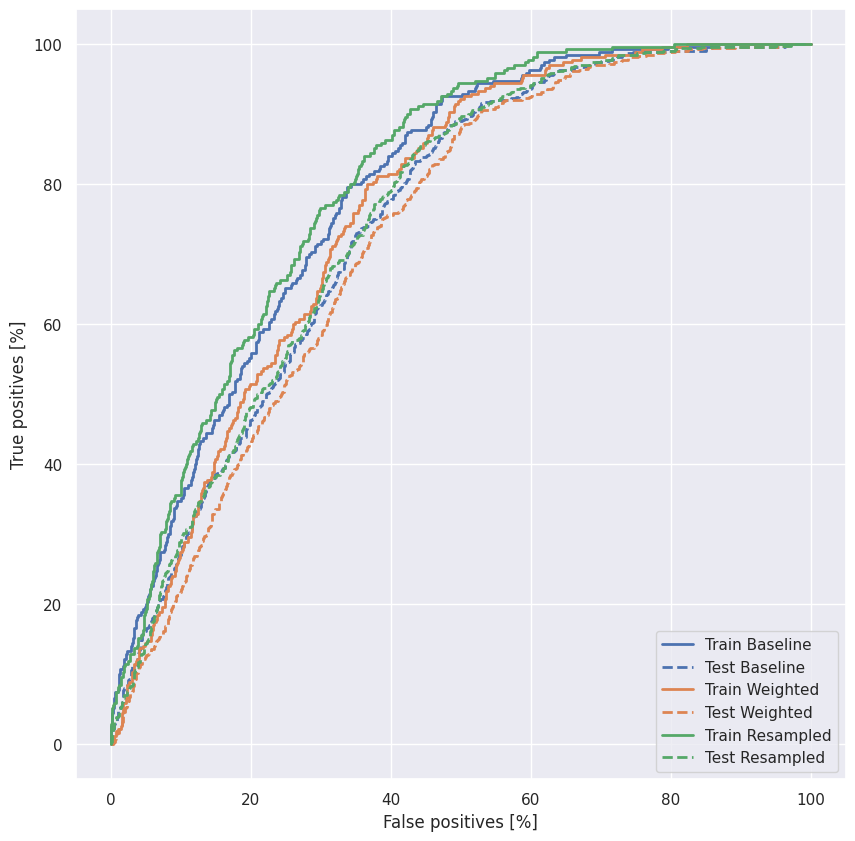

In [ ]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_roc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_roc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')

plot_roc("Train Resampled", train_labels, train_predictions_resampled, color=colors[2])
plot_roc("Test Resampled", test_labels, test_predictions_resampled, color=colors[2], linestyle='--')
plt.legend(loc='lower right');

### Plot the AUPRC


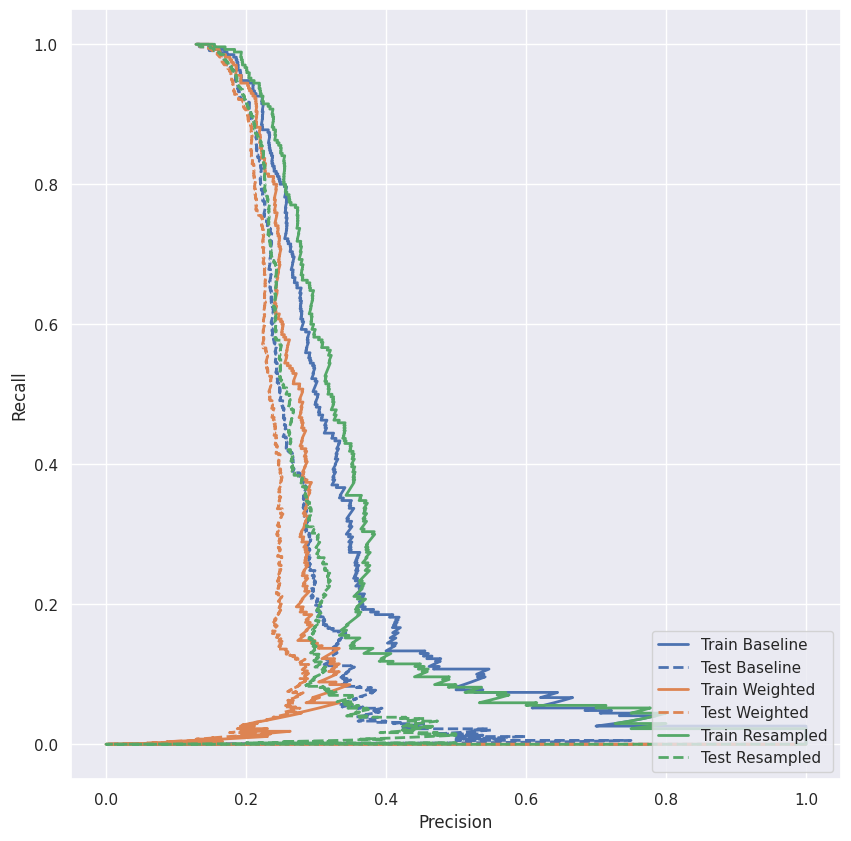

In [ ]:
plot_prc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_prc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_prc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_prc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')

plot_prc("Train Resampled", train_labels, train_predictions_resampled, color=colors[2])
plot_prc("Test Resampled", test_labels, test_predictions_resampled, color=colors[2], linestyle='--')
plt.legend(loc='lower right');

## Applying this tutorial to your problem

Imbalanced data classification is an inherently difficult task since there are so few samples to learn from. You should always start with the data first and do your best to collect as many samples as possible and give substantial thought to what features may be relevant so the model can get the most out of your minority class. At some point your model may struggle to improve and yield the results you want, so it is important to keep in mind the context of your problem and the trade offs between different types of errors.